# Detección de características de una persona a partir de una grabación de su voz.

## Objetivo
- A partir de las características obtenidas de una grabación de voz, determinar la edad, el sexo y si el inglés es la lengua nativa de una persona.

## Dataset

### Speech Accent Archive

- 2140 muestras grabadas de diferentes personas leyendo el mismo texto.
- Las personas proceden de 177 países y tienen 214 lenguas nativas diferentes.
- Cada persona habla inglés.


In [66]:
! cat dataset/reading-passage.txt

Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.


# Dataset load

In [ ]:
# Kaggle download, Only works on my own drive
# [How to kaggle] (https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

# Not needed anymore
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download rtatman/speech-accent-archive
! unzip -q speech-accent-archive.zip -d dataset

In [65]:
# Mount google drive folder and change working directory
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/IA-1/ai1-project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/IA-1/ai1-project'
/content/drive/MyDrive/IA-1/ai1-project


# Required libraries

In [ ]:
! pip -q install librosa
! pip -q install mutagen

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_squared_error


import os
import IPython.display as ipd
import librosa
import librosa.display
from mutagen.mp3 import MP3
import warnings

warnings.filterwarnings('ignore')

# First look at the data

In [ ]:
# Read speakers info file
data = pd.read_csv('dataset/speakers_all.csv')

In [ ]:
# Data Inspection
# Number of rows and columns
data.shape

(2172, 12)

In [ ]:
# Descripcion of index, entries, columns, data types, memory info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2172 non-null   float64
 1   age_onset        2172 non-null   float64
 2   birthplace       2168 non-null   object 
 3   filename         2172 non-null   object 
 4   native_language  2172 non-null   object 
 5   sex              2172 non-null   object 
 6   speakerid        2172 non-null   int64  
 7   country          2167 non-null   object 
 8   file_missing?    2172 non-null   bool   
 9   Unnamed: 9       0 non-null      float64
 10  Unnamed: 10      0 non-null      float64
 11  Unnamed: 11      1 non-null      object 
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 188.9+ KB


In [ ]:
# list all columns
data.columns

Index(['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex',
       'speakerid', 'country', 'file_missing?', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11'],
      dtype='object')

In [ ]:
# Check first few rows
data.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [ ]:
# Remove columns 9, 10, 11
data.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1, inplace=True)
data.columns
# Remove missing file rows
data.drop(data[data['file_missing?'] == 1].index, inplace = True)
data.head()
# Fix typo
data.loc[data['sex'] == 'famale']
data['sex'] = data['sex'].replace(['famale'],'female')
data['sex'].unique().size
# Remove missing filenames
data.drop(data[data['filename'] == 'nicaragua'].index, inplace = True)
data.drop(data[data['filename'] == 'sinhalese1'].index, inplace = True)

In [ ]:
# Finding minimun audio length
DIR = 'dataset/recordings/'
audio_time = []

for fn in os.listdir(DIR):
    audio = MP3(DIR + fn)
    audio_time.append(audio.info.length)

min = np.min(audio_time)
mean = np.mean(audio_time)
std = np.std(audio_time)
max = np.max(audio_time)
#print('Min length: ', min)
print('Mean: ', mean)
print('Std: ', std)
#print('Max length: ', max)

Mean:  27.716418136101886
Std:  8.044141948767283


In [ ]:
# File Example
wav, sr = librosa.load('dataset/recordings/hausa2.mp3', duration=27, sr=6000)
ipd.Audio('dataset/recordings/hausa2.mp3', rate=6000)

In [ ]:
wav.shape[0]

162001

# Building models

## Age Regression

In [ ]:
# Sample = 200
test_df = data.sample(200)

In [ ]:
# Reading and padding data

def pad(wav, pad_size=500):
    if wav.shape[0] > pad_size:
        return wav[0: pad_size]
    else:
        return np.hstack((wav, np.zeros(pad_size - wav.shape[0])))

def getDataXYR(df, padd, DATA_dir = 'dataset/recordings/'):
    X = []
    y = df['age']
    for fn in df['filename']:
        wav, sr = librosa.load(DATA_dir + fn + '.mp3', sr=6000)
        padded = pad(wav, padd)
        X.append(padded)
    return np.vstack(X), np.array(y)

X, y = getDataXYR(test_df, 162001)

In [ ]:
# Train test split
#! ls | wc -l = 2138

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print( 'X:', X.shape)
print( 'y:', y.shape)


X: (200, 162001)
y: (200,)


In [ ]:
# Model definition

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train[0].shape),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 162001)            0         
                                                                 
 dense_17 (Dense)            (None, 128)               20736256  
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,746,625
Trainable params: 20,746,625
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
5/5 [==============================] - 1s 91ms/step - loss: 34.7391 - mse: 1483.4899
Epoch 2/50
5/5 [==============================] - 0s 87ms/step - loss: 34.5344 - mse: 1469.1204
Epoch 3/50
5/5 [==============================] - 0s 88ms/step - loss: 34.3398 - mse: 1455.8013
Epoch 4/50
5/5 [==============================] - 0s 92ms/step - loss: 34.1243 - mse: 1441.1238
Epoch 5/50
5/5 [==============================] - 0s 89ms/step - loss: 33.8661 - mse: 1423.5421
Epoch 6/50
5/5 [==============================] - 0s 90ms/step - loss: 33.5350 - mse: 1401.1418
Epoch 7/50
5/5 [==============================] - 0s 86ms/step - loss: 33.0777 - mse: 1370.7897
Epoch 8/50
5/5 [==============================] - 0s 87ms/step - loss: 32.3933 - mse: 1326.6135
Epoch 9/50
5/5 [==============================] - 0s 92ms/step - loss: 31.2657 - mse: 1254.3350
Epoch 10/50
5/5 [==============================] - 0s 90ms/step - loss: 29.1181 - mse: 1126.9880
Epoch 11/50
5/5 [======================

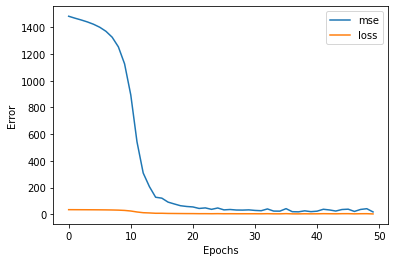

MSE:  496.3452952901216


In [ ]:
# Model fitting

model.compile(optimizer='SGD', 
                loss='mae',
                metrics=['mse'])

history = model.fit(X_train, y_train, epochs=50)

plt.plot(history.history['mse'], label="mse")
plt.plot(history.history['loss'], label="loss")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

mse = mean_squared_error(y_test, model.predict(X_test))

print('MSE: ', mse)

## Sex Classification

Female:  1036
Male:  1102


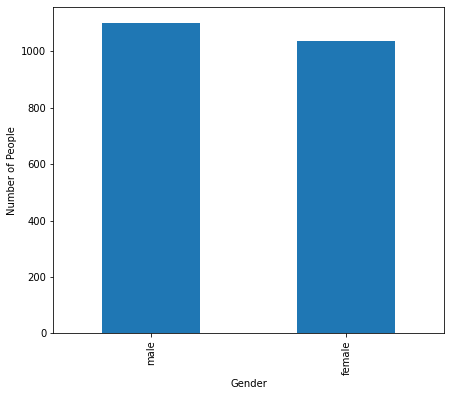

In [ ]:
# Sex plot
gender = data['sex'].value_counts()

plt.figure(figsize=(7, 6))
ax = gender.plot(kind='bar')
ax.set_xlabel('Gender')
ax.set_ylabel('Number of People')

print('Female: ',(data['sex'] == 'female').sum())
print('Male: ',(data['sex'] == 'male').sum())

In [ ]:
print('Female: ',(test_df['sex'] == 'female').sum())
print('Male: ',(test_df['sex'] == 'male').sum())
test_df['sex'] = test_df['sex'].replace(['female'],'0')
test_df['sex'] = test_df['sex'].replace(['male'],'1')
test_df.head()

Female:  98
Male:  102


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
995,23.0,14.0,"paris, france",french14,french,0,629,france,False
2071,24.0,11.0,"izmir, turkey",turkish35,turkish,0,2048,turkey,False
1101,19.0,11.0,"stuttgart, germany",german4,german,0,192,germany,False
899,18.0,0.0,"chesapeake, virginia, usa",english60,english,1,122,usa,False
1680,50.0,32.0,"birtem, romania",romanian3,romanian,1,297,romania,False


In [ ]:
# 
def pad(wav, pad_size=500):
    if wav.shape[0] > pad_size:
        return wav[0: pad_size]
    else:
        return np.hstack((wav, np.zeros(pad_size - wav.shape[0])))

def getDataXYR(df, padd, DATA_dir = 'dataset/recordings/'):
    X = []
    y = df['sex']
    for fn in df['filename']:
        wav, sr = librosa.load(DATA_dir + fn + '.mp3', sr=6000)
        padded = pad(wav, padd)
        X.append(padded)
    return np.vstack(X), np.array(y)

X, y = getDataXYR(test_df, 162001)

In [ ]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(y_train_ohe.shape, y_test_ohe.shape)
print( 'X:', X.shape)
print( 'y:', y.shape)

(160, 2) (40, 2)
X: (200, 162001)
y: (200,)


In [ ]:
# Exponential activation
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train[0].shape),
    tf.keras.layers.Dense(64, activation='exponential'),
    tf.keras.layers.Dense(32, activation='exponential'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

Epoch 1/50
5/5 [==============================] - 1s 65ms/step - loss: 1.5673 - accuracy: 0.5250
Epoch 2/50
5/5 [==============================] - 0s 65ms/step - loss: 0.3199 - accuracy: 0.9438
Epoch 3/50
5/5 [==============================] - 0s 60ms/step - loss: 0.1974 - accuracy: 0.9563
Epoch 4/50
5/5 [==============================] - 0s 61ms/step - loss: 0.1022 - accuracy: 1.0000
Epoch 5/50
5/5 [==============================] - 0s 62ms/step - loss: 0.0642 - accuracy: 1.0000
Epoch 6/50
5/5 [==============================] - 0s 61ms/step - loss: 0.0449 - accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 0s 58ms/step - loss: 0.0303 - accuracy: 1.0000
Epoch 8/50
5/5 [==============================] - 0s 61ms/step - loss: 0.0220 - accuracy: 1.0000
Epoch 9/50
5/5 [==============================] - 0s 61ms/step - loss: 0.0168 - accuracy: 1.0000
Epoch 10/50
5/5 [==============================] - 0s 67ms/step - loss: 0.0131 - accuracy: 1.0000
Epoch 11/50
5/5 [============

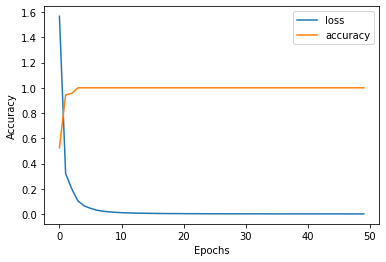

2/2 [==============================] - 0s 15ms/step - loss: 0.8539 - accuracy: 0.6250
0.625 0.8539298176765442


In [ ]:
# Model compile

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train_ohe, epochs=50)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['accuracy'], label="accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
test_loss, test_acc = model.evaluate(X_test, y_test_ohe)
print(test_acc, test_loss)

In [ ]:
# tanh activation
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train[0].shape),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

Epoch 1/50
5/5 [==============================] - 1s 60ms/step - loss: 0.6940 - accuracy: 0.5500
Epoch 2/50
5/5 [==============================] - 0s 61ms/step - loss: 0.6429 - accuracy: 0.8562
Epoch 3/50
5/5 [==============================] - 0s 62ms/step - loss: 0.5994 - accuracy: 0.9625
Epoch 4/50
5/5 [==============================] - 0s 59ms/step - loss: 0.5617 - accuracy: 0.9875
Epoch 5/50
5/5 [==============================] - 0s 60ms/step - loss: 0.5281 - accuracy: 1.0000
Epoch 6/50
5/5 [==============================] - 0s 64ms/step - loss: 0.4981 - accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 0s 61ms/step - loss: 0.4709 - accuracy: 1.0000
Epoch 8/50
5/5 [==============================] - 0s 58ms/step - loss: 0.4457 - accuracy: 1.0000
Epoch 9/50
5/5 [==============================] - 0s 64ms/step - loss: 0.4225 - accuracy: 1.0000
Epoch 10/50
5/5 [==============================] - 0s 66ms/step - loss: 0.4009 - accuracy: 1.0000
Epoch 11/50
5/5 [============

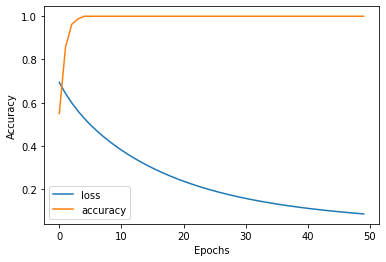

2/2 [==============================] - 0s 14ms/step - loss: 0.7373 - accuracy: 0.4000
0.4000000059604645 0.7373439073562622


In [ ]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train_ohe, epochs=50)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['accuracy'], label="accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
test_loss, test_acc = model.evaluate(X_test, y_test_ohe)
print(test_acc, test_loss)

In [ ]:
# Relu activation
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train[0].shape),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

Epoch 1/50
5/5 [==============================] - 1s 64ms/step - loss: 0.6933 - accuracy: 0.4625
Epoch 2/50
5/5 [==============================] - 0s 63ms/step - loss: 0.6824 - accuracy: 0.7250
Epoch 3/50
5/5 [==============================] - 0s 62ms/step - loss: 0.6735 - accuracy: 0.8938
Epoch 4/50
5/5 [==============================] - 0s 61ms/step - loss: 0.6659 - accuracy: 0.9500
Epoch 5/50
5/5 [==============================] - 0s 67ms/step - loss: 0.6590 - accuracy: 0.9750
Epoch 6/50
5/5 [==============================] - 0s 65ms/step - loss: 0.6526 - accuracy: 0.9875
Epoch 7/50
5/5 [==============================] - 0s 65ms/step - loss: 0.6464 - accuracy: 1.0000
Epoch 8/50
5/5 [==============================] - 0s 66ms/step - loss: 0.6406 - accuracy: 1.0000
Epoch 9/50
5/5 [==============================] - 0s 58ms/step - loss: 0.6350 - accuracy: 1.0000
Epoch 10/50
5/5 [==============================] - 0s 66ms/step - loss: 0.6294 - accuracy: 1.0000
Epoch 11/50
5/5 [============

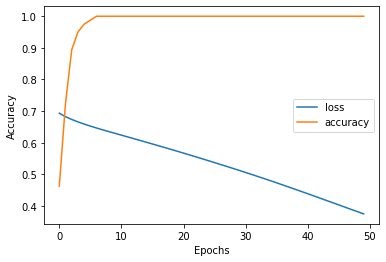

2/2 [==============================] - 0s 14ms/step - loss: 0.7059 - accuracy: 0.4500
0.44999998807907104 0.7059402465820312


In [ ]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train_ohe, epochs=50)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['accuracy'], label="accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
test_loss, test_acc = model.evaluate(X_test, y_test_ohe)
print(test_acc, test_loss)

## English as a native language

In [ ]:
# Native Language
nl = data.groupby("native_language").filter(lambda x: len(x) >40)

In [ ]:
# Native Languge  > 40
nl['native_language'].value_counts()

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
Name: native_language, dtype: int64

In [ ]:
# Set accent column values
nl['accent'] = nl['native_language'].apply(lambda x: '1' if x=='english' else '0')

In [ ]:
nl['accent'].value_counts()

0    587
1    579
Name: accent, dtype: int64

In [ ]:
# 
def getDataXYA(df, padd, DATA_dir = 'dataset/recordings/'):
    X = []
    y = df['accent']
    for fn in df['filename']:
        wav, sr = librosa.load(DATA_dir + fn + '.mp3', sr=6000)
        padded = pad(wav, padd)
        X.append(padded)
    return np.vstack(X), np.array(y)

X, y = getDataXYA(nl, 162001)

In [ ]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(y_train_ohe.shape, y_test_ohe.shape)
print( 'X:', X.shape)
print( 'y:', y.shape)

(932, 2) (234, 2)
X: (1166, 162001)
y: (1166,)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train[0].shape),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

Epoch 1/50
30/30 [==============================] - 3s 94ms/step - loss: 0.6920 - accuracy: 0.4968
Epoch 2/50
30/30 [==============================] - 3s 87ms/step - loss: 0.6764 - accuracy: 0.5858
Epoch 3/50
30/30 [==============================] - 3s 90ms/step - loss: 0.6632 - accuracy: 0.7114
Epoch 4/50
30/30 [==============================] - 3s 92ms/step - loss: 0.6506 - accuracy: 0.8240
Epoch 5/50
30/30 [==============================] - 3s 89ms/step - loss: 0.6380 - accuracy: 0.9024
Epoch 6/50
30/30 [==============================] - 3s 88ms/step - loss: 0.6244 - accuracy: 0.9399
Epoch 7/50
30/30 [==============================] - 3s 89ms/step - loss: 0.6093 - accuracy: 0.9689
Epoch 8/50
30/30 [==============================] - 3s 90ms/step - loss: 0.5925 - accuracy: 0.9871
Epoch 9/50
30/30 [==============================] - 3s 87ms/step - loss: 0.5737 - accuracy: 0.9936
Epoch 10/50
30/30 [==============================] - 3s 89ms/step - loss: 0.5522 - accuracy: 0.9989
Epoch 11/

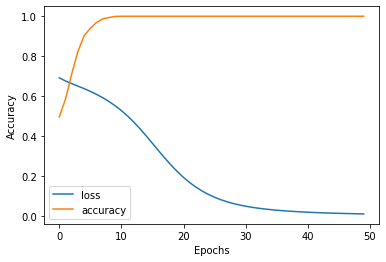

8/8 [==============================] - 0s 32ms/step - loss: 0.7951 - accuracy: 0.5000
0.5 0.7951405644416809


In [ ]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train_ohe, epochs=50)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['accuracy'], label="accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
test_loss, test_acc = model.evaluate(X_test, y_test_ohe)
print(test_acc, test_loss)

# Audio Features

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(220500,)


<Figure size 864x216 with 0 Axes>

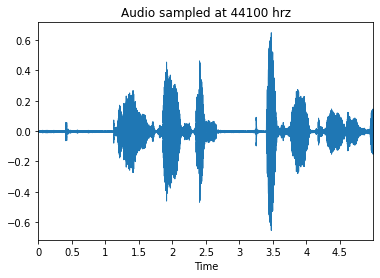

In [ ]:
## Female
SR = 44100
fname_f = 'recordings/recordings/english385.mp3'
y, sr = librosa.load(fname_f, sr=SR, duration=5)

plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 44100 hrz')
print(y.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(30001,)


<Figure size 864x216 with 0 Axes>

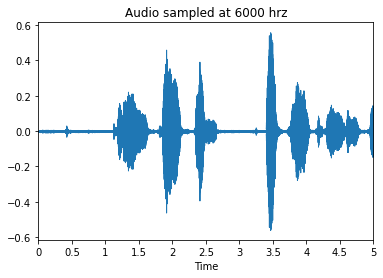

In [ ]:
SR = 6000
fname_f = 'recordings/recordings/english385.mp3'
y, sr = librosa.load(fname_f, sr=SR, duration=5)

plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 6000 hrz')
print(y.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(5000,)


<Figure size 864x216 with 0 Axes>

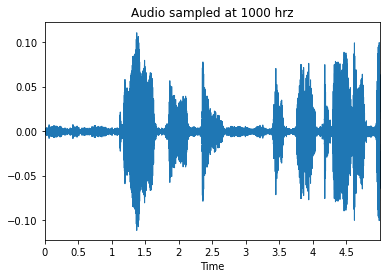

In [ ]:
SR = 1000
fname_f = 'recordings/recordings/english385.mp3'
y, sr = librosa.load(fname_f, sr=SR, duration=5)

plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 1000 hrz')
print(y.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(30001,)


<Figure size 864x216 with 0 Axes>

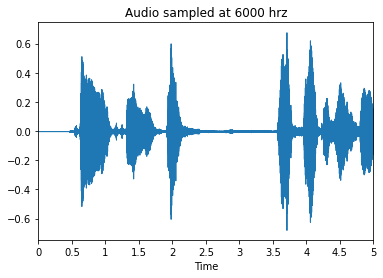

In [ ]:
## Male
SR = 6000
fname_f = 'recordings/recordings/english381.mp3'
y, sr = librosa.load(fname_f, sr=SR, duration=5)

plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Audio sampled at 6000 hrz')
print(y.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


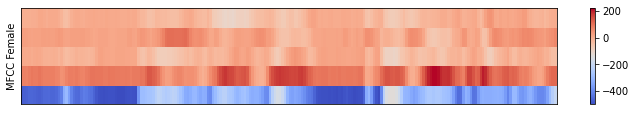

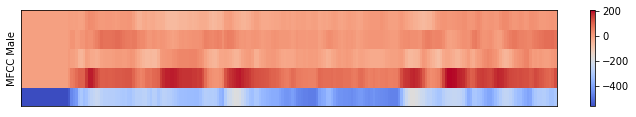

In [ ]:
## Mel-Frequency Cepstral Coefficient
# Male
SR = 22050
fname_f = 'recordings/recordings/english385.mp3'
y, sr = librosa.load(fname_f, sr=SR, duration = 5)
mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=5)

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC Female')
plt.colorbar()

# Female
fname_m = 'recordings/recordings/english381.mp3'
y, sr = librosa.load(fname_m, sr=SR, duration = 5)
mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=5)

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC Male')
plt.colorbar()

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


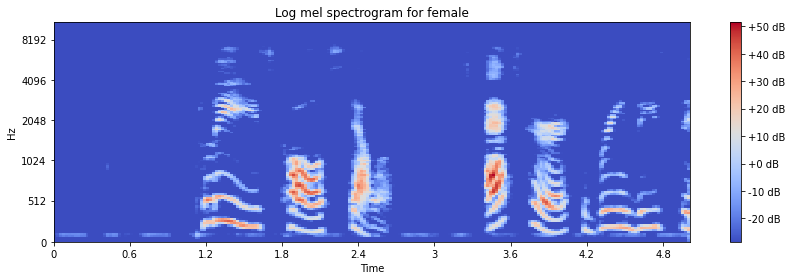

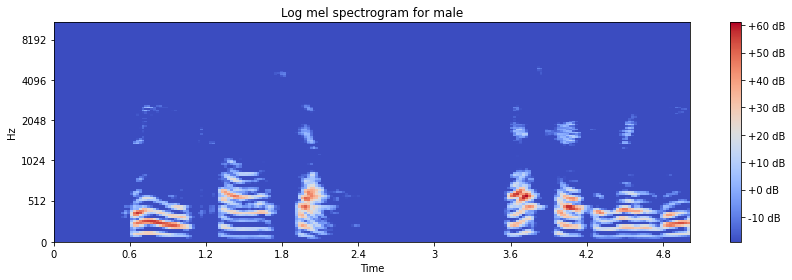

In [ ]:
## Log-Mel Spectrogram
## Female
SR = 22050
fname_f = 'recordings/recordings/english385.mp3'
y, sr = librosa.load(fname_f, sr=SR, duration = 5)
melspec = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

log_S = librosa.amplitude_to_db(melspec)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for female')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## Male
SR = 22050
fname_m = 'recordings/recordings/english381.mp3'
y, sr = librosa.load(fname_m, sr=SR, duration = 5)
melspec = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

log_S = librosa.amplitude_to_db(melspec)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for male')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


In [ ]:
## Harmonic-percussive source separation
SR=22050
fname_f = 'recordings/recordings/english385.mp3'
y, sr = librosa.load(fname_f, sr=SR, duration = 5)
y_harmonic, y_percussive = librosa.effects.hpss(y)

ipd.Audio(y_harmonic, rate=sr)
ipd.Audio(y_percussive, rate=sr)

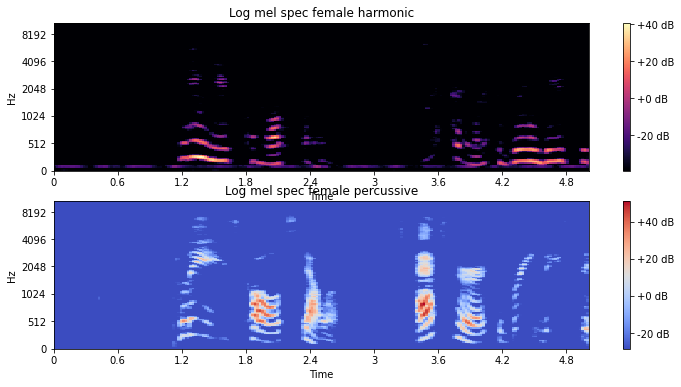

In [ ]:
# harmonic
melspec = librosa.feature.melspectrogram(y_harmonic, sr=sr, n_mels=128)
log_h = librosa.amplitude_to_db(melspec)

# percussive
melspec = librosa.feature.melspectrogram(y_percussive, sr=sr, n_mels=128)
log_p = librosa.amplitude_to_db(melspec)

plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
librosa.display.specshow(log_h, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spec female harmonic')
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_p, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spec female percussive')
plt.colorbar(format='%+02.0f dB')

In [ ]:
## HPSS v2

SR = 22050
fname_m = 'recordings/recordings/english381.mp3'
y, sr = librosa.load(fname_m, sr=SR, duration = 5)
X = librosa.stft(y)
H, P = librosa.decompose.hpss(X)

Hmag = librosa.amplitude_to_db(H)
Pmag = librosa.amplitude_to_db(P)

h = librosa.istft(H)
ipd.Audio(h, rate=SR)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


In [ ]:
p = librosa.istft(P)
ipd.Audio(p, rate=SR)

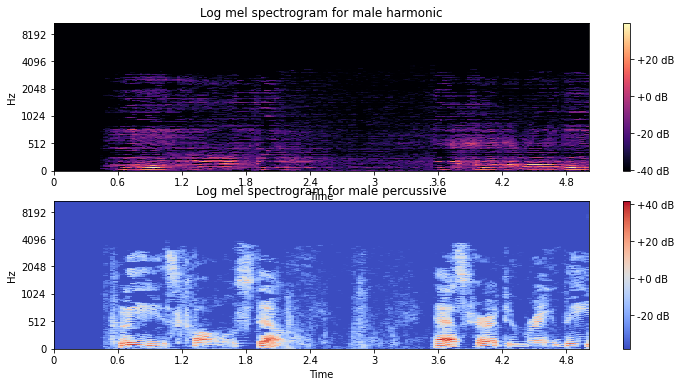

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
librosa.display.specshow(Hmag, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for male harmonic')
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(Pmag, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram for male percussive')
plt.colorbar(format='%+02.0f dB')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


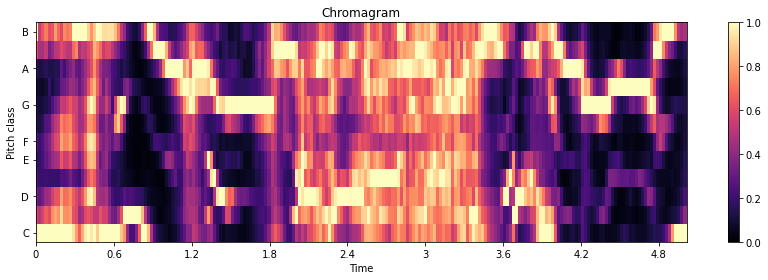

In [ ]:
## Chroma
SR = 22050
fname_f = 'recordings/recordings/english381.mp3'
y, sr = librosa.load(fname_f, sr=SR, duration = 5)
C = librosa.feature.chroma_cqt(y=y, sr=sr)

plt.figure(figsize=(12,4))
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


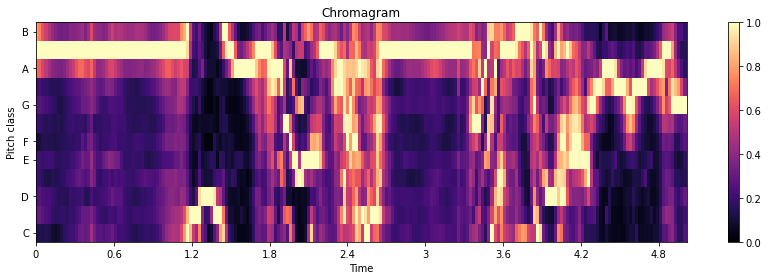

In [ ]:
SAMPLE_RATE = 22050
fname_f = 'recordings/recordings/english385.mp3'  
y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 5)
C = librosa.feature.chroma_cqt(y=y, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()